Importing the Bert tokenizer and showing an example embedding generated from it

In [17]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text, padding='max_length', max_length = 10, truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


Sets up the classification labels and data loader for parsing dataset

In [18]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'Look&Feel':0,
          'Usability':1,
          'Performance':2,
          'Operability':3,
          'Maintainability':4,
          'Security':5,
          }


class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['class_name']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['sentence']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Imports the data used for training and validation into a dataframe named df_for_training

In [19]:
import pandas as pd
df_for_training = pd.read_csv('./GPT_Datasets/Volere_GPT_NFR.csv') # enter the path to the dataset used for training here
df_for_training['sentence'] = df_for_training['sentence'].replace(",", "", regex=True)
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  3300 non-null   object
 1   sentence    3300 non-null   object
dtypes: object(2)
memory usage: 51.7+ KB


Imports the data used for testing into a dataframe named df_test

In [20]:
df_test = pd.read_csv('./Balanced_Testing_Datasets/Volere_NFR_Balanced.csv') # enter the path to the dataset used for testing here
df_test['sentence'] = df_test['sentence'].replace(",", "", regex=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  90 non-null     object
 1   sentence    90 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


Removes duplicates from the df_for_training dataset that is within the df_test dataset

In [21]:
df_for_training = df_for_training[~df_for_training['sentence'].isin(df_test['sentence'])]
df_for_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3277 entries, 0 to 3299
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  3277 non-null   object
 1   sentence    3277 non-null   object
dtypes: object(2)
memory usage: 76.8+ KB


Splits the data used for training and validation into separate dataframes 

In [22]:
np.random.seed(112)
df_train, df_val, df_test_not_used = np.split(df_for_training.sample(frac=1, random_state=42), 
                                     [int(.8*len(df_for_training)), int(.9*len(df_for_training))])

print(len(df_train),len(df_val), len(df_test))
print("-----------------------df_train---------------------------")
df_train.info()
df_train.groupby('class_name').describe()

2621 328 90
-----------------------df_train---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2621 entries, 2970 to 133
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  2621 non-null   object
 1   sentence    2621 non-null   object
dtypes: object(2)
memory usage: 61.4+ KB


sentence         \
                   count unique   
class_name                        
Look&Feel            496    384   
Maintainability      489    489   
Operability          384    369   
Performance          469    393   
Security             391    316   
Usability            392    383   

                                                                         
                                                               top freq  
class_name                                                               
Look&Feel        The user interface should offer a visually sti...    6  
Maintainability  The product must integrate with the National C...    1  
Operability      The product shall be available for distributio...    2  
Performance      The system should accommodate a minimum of 8 s...    2  
Security         User authentication tokens shall have a limite...    3  
Usability        Users shall receive context-aware recommendati...    2

In [23]:
print("-----------------------df_val---------------------------")
df_val.info()
df_val.groupby('class_name').describe()

-----------------------df_val---------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 1141 to 1535
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  328 non-null    object
 1   sentence    328 non-null    object
dtypes: object(2)
memory usage: 7.7+ KB


sentence         \
                   count unique   
class_name                        
Look&Feel             54     54   
Maintainability       51     51   
Operability           46     46   
Performance           59     59   
Security              53     51   
Usability             65     65   

                                                                         
                                                               top freq  
class_name                                                               
Look&Feel        The software's design should immerse players i...    1  
Maintainability  The software's modular architecture should all...    1  
Operability      The System shall be able to automatically back...    1  
Performance      The application should complete every user tra...    1  
Security         The system shall log and retain records of use...    2  
Usability         Users shall have the option to enable Smart R...    1

In [24]:
print("-----------------------df_test---------------------------")
df_test.info()
df_test.groupby('class_name').describe()

-----------------------df_test---------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   class_name  90 non-null     object
 1   sentence    90 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


sentence         \
                   count unique   
class_name                        
Look&Feel             15     15   
Maintainability       15     15   
Operability           15     15   
Performance           15     15   
Security              15     15   
Usability             15     15   

                                                                         
                                                               top freq  
class_name                                                               
Look&Feel        The application shall match the color of the s...    1  
Maintainability  Maintenance releases will be offered to custom...    1  
Operability      The system shall able to operate within a busi...    1  
Performance      The system shall refresh the display every 60 ...    1  
Security         The product shall ensure that it can only be a...    1  
Usability        If projected the data must be readable.  On a ...    1

Constructor for the neural network object

In [25]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 6)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer


Training loop of the model (read comments at the bottom of the code block!)

In [60]:
from torch.optim import Adam
from tqdm import tqdm
import sklearn 

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss() # eddit the weigth parameter of the model to help with particular classes that are not being correctly predicted
    optimizer = Adam(model.parameters(), lr= learning_rate, weight_decay=0.01) # edit weight_decay to help with overfitting

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
model = BertClassifier()
EPOCHS = 35 # lower the epocs if you are using a cpu or are NOT using a gpu stronger than a 4090 (for reference it takes roughly 1 hour to train the model on an A6000)
LR = 1e-5 # adjusting learning rate can help with accuracy 

train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1311/1311 [01:47<00:00, 12.22it/s]


Epochs: 1 | Train Loss:  0.453                 | Train Accuracy:  0.673                 | Val Loss:  0.248                 | Val Accuracy:  0.851


100%|██████████| 1311/1311 [01:49<00:00, 12.02it/s]


Epochs: 2 | Train Loss:  0.153                 | Train Accuracy:  0.908                 | Val Loss:  0.222                 | Val Accuracy:  0.857


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 3 | Train Loss:  0.067                 | Train Accuracy:  0.958                 | Val Loss:  0.204                 | Val Accuracy:  0.890


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 4 | Train Loss:  0.037                 | Train Accuracy:  0.979                 | Val Loss:  0.199                 | Val Accuracy:  0.890


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 5 | Train Loss:  0.020                 | Train Accuracy:  0.990                 | Val Loss:  0.319                 | Val Accuracy:  0.851


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 6 | Train Loss:  0.022                 | Train Accuracy:  0.988                 | Val Loss:  0.271                 | Val Accuracy:  0.866


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 7 | Train Loss:  0.014                 | Train Accuracy:  0.992                 | Val Loss:  0.305                 | Val Accuracy:  0.878


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 8 | Train Loss:  0.023                 | Train Accuracy:  0.987                 | Val Loss:  0.271                 | Val Accuracy:  0.881


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 9 | Train Loss:  0.009                 | Train Accuracy:  0.994                 | Val Loss:  0.314                 | Val Accuracy:  0.875


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 10 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.282                 | Val Accuracy:  0.890


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 11 | Train Loss:  0.001                 | Train Accuracy:  0.999                 | Val Loss:  0.314                 | Val Accuracy:  0.890


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 12 | Train Loss:  0.017                 | Train Accuracy:  0.990                 | Val Loss:  0.312                 | Val Accuracy:  0.890


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 13 | Train Loss:  0.006                 | Train Accuracy:  0.996                 | Val Loss:  0.301                 | Val Accuracy:  0.884


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 14 | Train Loss:  0.011                 | Train Accuracy:  0.994                 | Val Loss:  0.292                 | Val Accuracy:  0.881


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 15 | Train Loss:  0.016                 | Train Accuracy:  0.992                 | Val Loss:  0.309                 | Val Accuracy:  0.893


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 16 | Train Loss:  0.016                 | Train Accuracy:  0.993                 | Val Loss:  0.311                 | Val Accuracy:  0.872


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 17 | Train Loss:  0.011                 | Train Accuracy:  0.993                 | Val Loss:  0.323                 | Val Accuracy:  0.887


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 18 | Train Loss:  0.007                 | Train Accuracy:  0.996                 | Val Loss:  0.312                 | Val Accuracy:  0.893


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 19 | Train Loss:  0.003                 | Train Accuracy:  0.998                 | Val Loss:  0.336                 | Val Accuracy:  0.890


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 20 | Train Loss:  0.002                 | Train Accuracy:  0.999                 | Val Loss:  0.369                 | Val Accuracy:  0.893


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 21 | Train Loss:  0.015                 | Train Accuracy:  0.995                 | Val Loss:  0.266                 | Val Accuracy:  0.896


100%|██████████| 1311/1311 [01:49<00:00, 11.98it/s]


Epochs: 22 | Train Loss:  0.006                 | Train Accuracy:  0.996                 | Val Loss:  0.388                 | Val Accuracy:  0.866


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 23 | Train Loss:  0.012                 | Train Accuracy:  0.994                 | Val Loss:  0.346                 | Val Accuracy:  0.848


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 24 | Train Loss:  0.006                 | Train Accuracy:  0.997                 | Val Loss:  0.417                 | Val Accuracy:  0.866


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 25 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.330                 | Val Accuracy:  0.881


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 26 | Train Loss:  0.005                 | Train Accuracy:  0.996                 | Val Loss:  0.378                 | Val Accuracy:  0.866


100%|██████████| 1311/1311 [01:49<00:00, 11.96it/s]


Epochs: 27 | Train Loss:  0.005                 | Train Accuracy:  0.998                 | Val Loss:  0.367                 | Val Accuracy:  0.878


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 28 | Train Loss:  0.001                 | Train Accuracy:  0.999                 | Val Loss:  0.369                 | Val Accuracy:  0.884


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 29 | Train Loss:  0.007                 | Train Accuracy:  0.996                 | Val Loss:  0.404                 | Val Accuracy:  0.872


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 30 | Train Loss:  0.007                 | Train Accuracy:  0.997                 | Val Loss:  0.329                 | Val Accuracy:  0.896


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 31 | Train Loss:  0.006                 | Train Accuracy:  0.997                 | Val Loss:  0.365                 | Val Accuracy:  0.854


100%|██████████| 1311/1311 [01:49<00:00, 11.96it/s]


Epochs: 32 | Train Loss:  0.013                 | Train Accuracy:  0.992                 | Val Loss:  0.373                 | Val Accuracy:  0.884


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 33 | Train Loss:  0.008                 | Train Accuracy:  0.995                 | Val Loss:  0.353                 | Val Accuracy:  0.896


100%|██████████| 1311/1311 [01:49<00:00, 11.96it/s]


Epochs: 34 | Train Loss:  0.004                 | Train Accuracy:  0.997                 | Val Loss:  0.339                 | Val Accuracy:  0.899


100%|██████████| 1311/1311 [01:49<00:00, 11.97it/s]


Epochs: 35 | Train Loss:  0.001                 | Train Accuracy:  0.999                 | Val Loss:  0.387                 | Val Accuracy:  0.887


Function to generate multilabel confusion matrix

In [26]:
from sklearn.metrics import confusion_matrix
import itertools 
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('true label')
    plt.xlabel('Predicted label')


Testing loop for the model

will show:

- accuracy, precision, recall, and F1 scores of the model on the testing dataset

- each sentence it predicted incorrectly along with the prediction it made instead

- a multi-label confusion matrix to show how each class performed

Look&Feel (true) -> Operability (pred): The application shall match the color of the schema set forth by Department of Homeland Security
Look&Feel (true) -> Usability (pred): The system shall have a professional appearance
Look&Feel (true) -> Maintainability (pred): The Disputes application shall comply with the corporate standards for user interface creation for internally and externally used applications.
Look&Feel (true) -> Usability (pred): The product shall comply with corporate User Interface Guidelines
Usability (true) -> Look&Feel (pred): If projected the data must be readable.  On a 10x10 projection screen  90% of viewers must be able to read Event / Activity data from a viewing distance of 30.
Performance (true) -> Operability (pred): The product shall synchronize with the office system every hour.
Performance (true) -> Usability (pred): Staff members shall be able to complete a set of tasks in a timely manner.
Maintainability (true) -> Performance (pred): Maintenance release

{'Accuracy:  0.867', 'F1 Score:  0.866', 'Percision:  0.877', 'Recall:  0.867'}

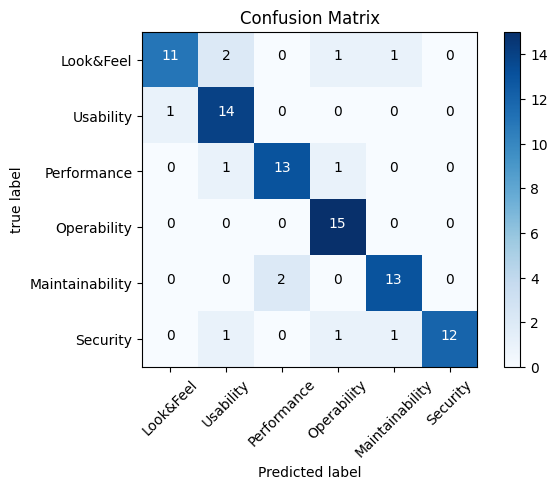

In [62]:
from pandas import DataFrame
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
)

def evaluate(model, test_data: DataFrame):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    test_pred = []
    test_true = []
    test_class = test_data['class_name'].tolist()
    test_sentence = test_data['sentence'].tolist()
    test_pred_class = ['Look&Feel', 'Usability', 'Performance', 'Operability', 'Maintainability', 'Security']

    with torch.no_grad():
    
        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              _, predicted = torch.max(output.data, 1)
              test_pred.extend(predicted.cpu().numpy())
              test_true.extend(test_label.cpu().numpy())
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    for i in range(len(test_pred)):
        if(test_true[i] != test_pred[i]):
            print(test_class[i] + " (true) -> " + test_pred_class[test_pred[i]] + " (pred): " + test_sentence[i] )

    cm = confusion_matrix(test_true, test_pred)
    cm_plot_labels = ['Look&Feel', 'Usability', 'Performance', 'Operability', 'Maintainability', 'Security']
    plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')
    # print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
    return {f"Accuracy: {total_acc_test / len(test_data): .3f}",
             f"F1 Score: {f1_score(test_true, test_pred, average='weighted'): .3f}", 
             f"Percision: {precision_score(test_true, test_pred, average='weighted'): .3f}",
             f"Recall: {recall_score(test_true, test_pred, average='weighted'): .3f}"}
    
evaluate(model, df_test)